# What's My Flight Status?
***
Author: Andre Layton
***



# Overview
Notes: Construct like an abstract - summary of my entire analysis: 
mention dataset sources, my workflow steps and process, results, evaluations, and conclusions drawn!

# Business Problem

<img src="https://res.cloudinary.com/sagacity/image/upload/c_crop,h_2799,w_4199,x_0,y_0/c_limit,dpr_auto,f_auto,fl_lossy,q_80,w_1080/shutterstock_402702424_dlgrgk.jpg" style="height:650px" />

# Data Understanding 


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
from IPython.display import HTML
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, classification_report,\
                            roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import svm
from sklearn.inspection import permutation_importance
import joblib

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers, optimizers
from keras.applications import ResNet50
import os, shutil, random

# Create a seed for reproducibility
seed=24

In [2]:
# Load the metadata (column descriptions)
metadata = open("data/raw_data_documentation.txt", "r")
print(metadata.read())

AIRPORT_COORDINATES
	ORIGIN_AIRPORT_ID: 	Airport ID, matches to ORIGIN_AIRPORT_ID in other files
	DISPLAY_AIRPORT_NAME:  	Display Airport, matches to DISPLAY_AIRPORT_NAME in other files
	LATITUDE: 		Latitude for airport
	LONGITUDE: 		Longitude for airport

B43_AIRCRAFT_INVENTORY
	MANUFACTURE_YEAR: 	Manufacture year
	TAIL_NUM: 		Unique tail number, matches to TAIL_NUM in other files
	NUMBER_OF_SEATS: 	Number of seats on aircraft
	
CARRIER_DECODE
	AIRLINE_ID: 		Airport ID, matches to AIRLINE_ID in other files
	OP_UNIQUE_CARRIER: 	Carrier code, matches to OP_UNIQUE_CARRIER in other files
	CARRIER_NAME: 		Carrier name, matches to UNIQUE_CARRIER_NAME or CARRIER_NAME in other files

ONTIME_REPORTING_XX
	MONTH: 			Month
	DAY_OF_MONTH: 		Day of the month (1-31)
	DAY_OF_WEEK: 		Day of the week
	OP_UNIQUE_CARRIER: 	Carrier code, matches to OP_UNIQUE_CARRIER in other files
	TAIL_NUM: 		Unique tail number, matches to TAIL_NUM in other files
	OP_CARRIER_FL_NUM: 	Flight number
	ORIGIN_AIRPORT_ID: 	A

In [3]:
# Load flight data
data = pd.read_csv('data/full_data_flightdelay.csv')

# Preview the first 15 records
data.head(15)

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,1,7,0,0800-0859,2,1,25,143,Southwest Airlines Co.,13056,...,8,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
1,1,7,0,0700-0759,7,1,29,191,Delta Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
2,1,7,0,0600-0659,7,1,27,199,Delta Air Lines Inc.,13056,...,18,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
3,1,7,0,0600-0659,9,1,27,180,Delta Air Lines Inc.,13056,...,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
4,1,7,0,0001-0559,7,1,10,182,Spirit Air Lines,13056,...,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
5,1,7,0,0001-0559,3,1,10,180,Frontier Airlines Inc.,13056,...,5,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
6,1,7,0,0700-0759,6,1,29,186,Frontier Airlines Inc.,13056,...,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
7,1,7,1,0001-0559,7,1,10,186,Frontier Airlines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
8,1,7,0,0001-0559,7,1,10,180,Frontier Airlines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
9,1,7,0,0600-0659,8,1,27,186,Frontier Airlines Inc.,13056,...,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91


In [4]:
# Examine column information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6489062 entries, 0 to 6489061
Data columns (total 26 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   MONTH                          int64  
 1   DAY_OF_WEEK                    int64  
 2   DEP_DEL15                      int64  
 3   DEP_TIME_BLK                   object 
 4   DISTANCE_GROUP                 int64  
 5   SEGMENT_NUMBER                 int64  
 6   CONCURRENT_FLIGHTS             int64  
 7   NUMBER_OF_SEATS                int64  
 8   CARRIER_NAME                   object 
 9   AIRPORT_FLIGHTS_MONTH          int64  
 10  AIRLINE_FLIGHTS_MONTH          int64  
 11  AIRLINE_AIRPORT_FLIGHTS_MONTH  int64  
 12  AVG_MONTHLY_PASS_AIRPORT       int64  
 13  AVG_MONTHLY_PASS_AIRLINE       int64  
 14  FLT_ATTENDANTS_PER_PASS        float64
 15  GROUND_SERV_PER_PASS           float64
 16  PLANE_AGE                      int64  
 17  DEPARTING_AIRPORT              object 
 18  LA

In [5]:
# Find the amount of missing values in each column
data.isna().sum()

MONTH                            0
DAY_OF_WEEK                      0
DEP_DEL15                        0
DEP_TIME_BLK                     0
DISTANCE_GROUP                   0
SEGMENT_NUMBER                   0
CONCURRENT_FLIGHTS               0
NUMBER_OF_SEATS                  0
CARRIER_NAME                     0
AIRPORT_FLIGHTS_MONTH            0
AIRLINE_FLIGHTS_MONTH            0
AIRLINE_AIRPORT_FLIGHTS_MONTH    0
AVG_MONTHLY_PASS_AIRPORT         0
AVG_MONTHLY_PASS_AIRLINE         0
FLT_ATTENDANTS_PER_PASS          0
GROUND_SERV_PER_PASS             0
PLANE_AGE                        0
DEPARTING_AIRPORT                0
LATITUDE                         0
LONGITUDE                        0
PREVIOUS_AIRPORT                 0
PRCP                             0
SNOW                             0
SNWD                             0
TMAX                             0
AWND                             0
dtype: int64

In [6]:
# Preview statistical breakdown 
data.describe()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,...,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,LATITUDE,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND
count,6.489062e+06,6.489062e+06,6.489062e+06,6.489062e+06,6.489062e+06,6.489062e+06,6.489062e+06,6.489062e+06,6.489062e+06,6.489062e+06,...,6.489062e+06,6.489062e+06,6.489062e+06,6.489062e+06,6.489062e+06,6.489062e+06,6.489062e+06,6.489062e+06,6.489062e+06,6.489062e+06
mean,6.607062e+00,3.935598e+00,1.891441e-01,3.821102e+00,3.046890e+00,2.783675e+01,1.337397e+02,1.268458e+04,6.296058e+04,3.459251e+03,...,9.753707e-05,1.355612e-04,1.153211e+01,3.670581e+01,-9.425515e+01,1.037063e-01,3.159310e-02,9.152397e-02,7.146846e+01,8.341329e+00
std,3.396853e+00,1.995200e+00,3.916231e-01,2.382233e+00,1.757864e+00,2.151060e+01,4.645213e+01,8.839796e+03,3.438223e+04,4.251139e+03,...,8.644459e-05,4.649970e-05,6.935706e+00,5.500804e+00,1.790952e+01,3.432134e-01,3.170163e-01,7.281285e-01,1.835333e+01,3.607604e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.400000e+01,1.100000e+03,5.582000e+03,1.000000e+00,...,0.000000e+00,7.134695e-06,0.000000e+00,1.844000e+01,-1.593460e+02,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+01,0.000000e+00
25%,4.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,1.100000e+01,9.000000e+01,5.345000e+03,2.503400e+04,6.540000e+02,...,3.419267e-05,9.889412e-05,5.000000e+00,3.343600e+01,-1.063770e+02,0.000000e+00,0.000000e+00,0.000000e+00,5.900000e+01,5.820000e+00
50%,7.000000e+00,4.000000e+00,0.000000e+00,3.000000e+00,3.000000e+00,2.300000e+01,1.430000e+02,1.156200e+04,7.087800e+04,2.251000e+03,...,6.178236e-05,1.246511e-04,1.200000e+01,3.750500e+01,-8.790600e+01,0.000000e+00,0.000000e+00,0.000000e+00,7.400000e+01,7.830000e+00
75%,1.000000e+01,6.000000e+00,0.000000e+00,5.000000e+00,4.000000e+00,3.900000e+01,1.720000e+02,1.761500e+04,8.631200e+04,4.806000e+03,...,1.441659e-04,1.772872e-04,1.700000e+01,4.077900e+01,-8.093600e+01,2.000000e-02,0.000000e+00,0.000000e+00,8.600000e+01,1.029000e+01
max,1.200000e+01,7.000000e+00,1.000000e+00,1.100000e+01,1.500000e+01,1.090000e+02,3.370000e+02,3.525600e+04,1.177280e+05,2.183700e+04,...,3.484077e-04,2.289855e-04,3.200000e+01,6.116900e+01,-6.600200e+01,1.163000e+01,1.720000e+01,2.520000e+01,1.150000e+02,3.378000e+01


In [18]:
# Make a copy of the dataset
data2 = data.copy()

In [19]:
# Drop unnecessary columns 
cols_to_drop = ['SEGMENT_NUMBER', 'NUMBER_OF_SEATS', 'FLT_ATTENDANTS_PER_PASS', 'GROUND_SERV_PER_PASS']
data2 = data2.drop(cols_to_drop, axis=1)
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6489062 entries, 0 to 6489061
Data columns (total 22 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   MONTH                          int64  
 1   DAY_OF_WEEK                    int64  
 2   DEP_DEL15                      int64  
 3   DEP_TIME_BLK                   object 
 4   DISTANCE_GROUP                 int64  
 5   CONCURRENT_FLIGHTS             int64  
 6   CARRIER_NAME                   object 
 7   AIRPORT_FLIGHTS_MONTH          int64  
 8   AIRLINE_FLIGHTS_MONTH          int64  
 9   AIRLINE_AIRPORT_FLIGHTS_MONTH  int64  
 10  AVG_MONTHLY_PASS_AIRPORT       int64  
 11  AVG_MONTHLY_PASS_AIRLINE       int64  
 12  PLANE_AGE                      int64  
 13  DEPARTING_AIRPORT              object 
 14  LATITUDE                       float64
 15  LONGITUDE                      float64
 16  PREVIOUS_AIRPORT               object 
 17  PRCP                           float64
 18  SN

In [20]:
# Rename the columns for easier comprehension & list the first 5 records
new_col_names = {'DEP_DEL15': 'DELAYED',
                'PRCP': 'PRECIPITATION',
                'SNWD': 'SNOW_ON_GROUND',
                'TMAX': 'MAX_TEMP_FOR_DAY',
                'AWND': 'MAX_WIND_FOR_DAY'}
data2 = data2.rename(new_col_names, axis=1)
data2.head()

,MONTH,DAY_OF_WEEK,DELAYED,DEP_TIME_BLK,DISTANCE_GROUP,CONCURRENT_FLIGHTS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY
0,1,7,0,0800-0859,2,25,Southwest Airlines Co.,13056,107363,5873,...,8,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
1,1,7,0,0700-0759,7,29,Delta Air Lines Inc.,13056,73508,1174,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
2,1,7,0,0600-0659,7,27,Delta Air Lines Inc.,13056,73508,1174,...,18,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
3,1,7,0,0600-0659,9,27,Delta Air Lines Inc.,13056,73508,1174,...,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
4,1,7,0,0001-0559,7,10,Spirit Air Lines,13056,15023,1257,...,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
5,1,7,0,0001-0559,3,10,Frontier Airlines Inc.,13056,9496,581,...,5,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
6,1,7,0,0700-0759,6,29,Frontier Airlines Inc.,13056,9496,581,...,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
7,1,7,1,0001-0559,7,10,Frontier Airlines Inc.,13056,9496,581,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
8,1,7,0,0001-0559,7,10,Frontier Airlines Inc.,13056,9496,581,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
9,1,7,0,0600-0659,8,27,Frontier Airlines Inc.,13056,9496,581,...,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91


In [23]:
# Shift the target column to the end 
cols_at_end = ['DELAYED']
data2 = data2[[col for col in data2 if col not in cols_at_end] 
        + [col for col in cols_at_end if col in data2]]

# Preview the first 5 records to confirm the change
data2.head()

,MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,CONCURRENT_FLIGHTS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,...,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY,DELAYED
0,1,7,0800-0859,2,25,Southwest Airlines Co.,13056,107363,5873,1903352,...,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,0
1,1,7,0700-0759,7,29,Delta Air Lines Inc.,13056,73508,1174,1903352,...,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,0
2,1,7,0600-0659,7,27,Delta Air Lines Inc.,13056,73508,1174,1903352,...,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,0
3,1,7,0600-0659,9,27,Delta Air Lines Inc.,13056,73508,1174,1903352,...,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,0
4,1,7,0001-0559,7,10,Spirit Air Lines,13056,15023,1257,1903352,...,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,0
5,1,7,0001-0559,3,10,Frontier Airlines Inc.,13056,9496,581,1903352,...,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,0
6,1,7,0700-0759,6,29,Frontier Airlines Inc.,13056,9496,581,1903352,...,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,0
7,1,7,0001-0559,7,10,Frontier Airlines Inc.,13056,9496,581,1903352,...,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,1
8,1,7,0001-0559,7,10,Frontier Airlines Inc.,13056,9496,581,1903352,...,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,0
9,1,7,0600-0659,8,27,Frontier Airlines Inc.,13056,9496,581,1903352,...,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91,0


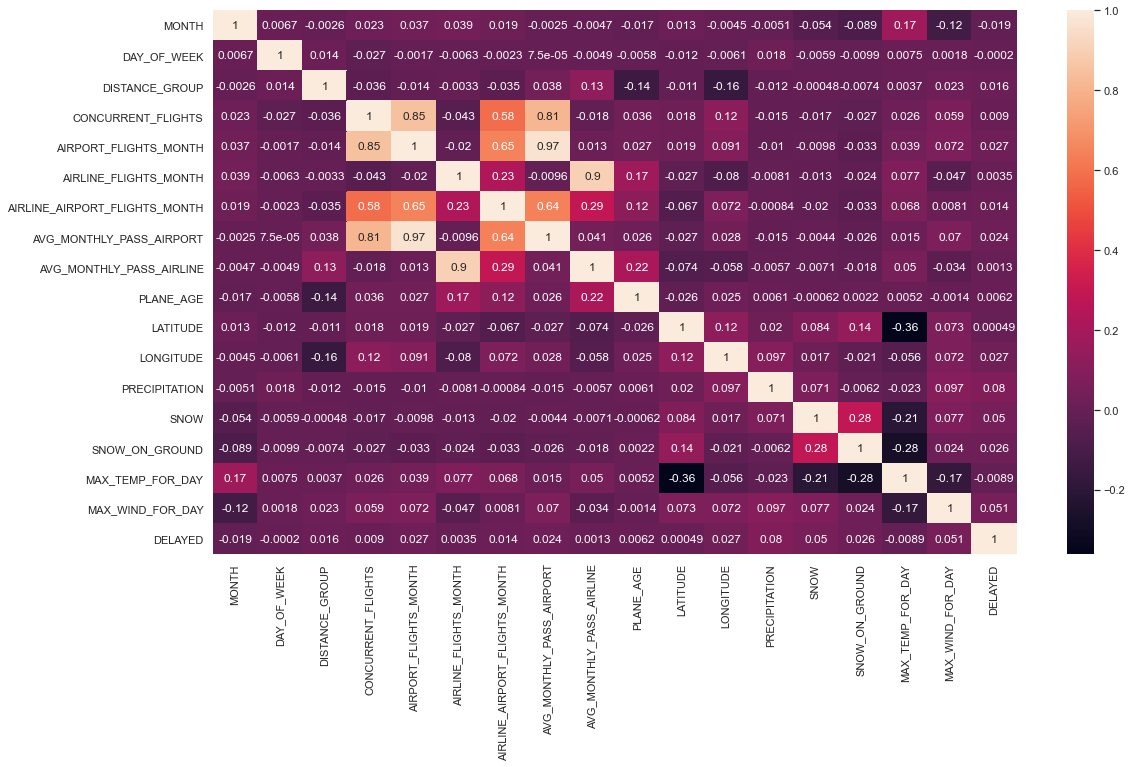

In [24]:
# Plot a heatmap with the Pearson coefficient values listed
sns.set(rc={'figure.figsize':(18, 10)})
sns.heatmap(data2.corr(), annot=True);